In [1]:
!pip install opencv-python

<h2>Importing the required modules</h2>

In [2]:
#from imutils import paths
import numpy as np
import pandas as pd
import seaborn as sns
import argparse
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_img
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import torch
from torchvision import transforms
from sklearn.pipeline import Pipeline

2024-07-22 16:18:13.906955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 16:18:13.907070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 16:18:14.043240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
directory = "/kaggle/input/layouts/layouts/E7-images"

<h2>Loading the images from Directory</h2>

In [4]:
def load_images_from_directory(directory):
    images = []
    files = os.listdir(directory)

    for filename in files:
        if filename.lower().endswith('.jpg'):
            filepath = os.path.join(directory, filename)

            image = cv2.imread(filepath)

            if image is not None:
                images.append(image)
                print(f"Loaded image: {filename}, Shape: {image.shape}")
            else:
                print(f"Failed to read image: {filename}")

    return images

In [5]:
images = load_images_from_directory(directory)

Loaded image: 0664.jpg, Shape: (480, 640, 3)
Loaded image: 0733.jpg, Shape: (480, 640, 3)
Loaded image: 0106.jpg, Shape: (480, 640, 3)
Loaded image: 0375.jpg, Shape: (480, 640, 3)
Loaded image: 1075.jpg, Shape: (480, 640, 3)
Loaded image: 0285.jpg, Shape: (480, 640, 3)
Loaded image: 0591.jpg, Shape: (480, 640, 3)
Loaded image: 0799.jpg, Shape: (480, 640, 3)
Loaded image: 0074.jpg, Shape: (480, 640, 3)
Loaded image: 1031.jpg, Shape: (480, 640, 3)
Loaded image: 0077.jpg, Shape: (480, 640, 3)
Loaded image: 0498.jpg, Shape: (480, 640, 3)
Loaded image: 0610.jpg, Shape: (480, 640, 3)
Loaded image: 0617.jpg, Shape: (480, 640, 3)
Loaded image: 1024.jpg, Shape: (480, 640, 3)
Loaded image: 0426.jpg, Shape: (480, 640, 3)
Loaded image: 0989.jpg, Shape: (480, 640, 3)
Loaded image: 0235.jpg, Shape: (480, 640, 3)
Loaded image: 0273.jpg, Shape: (480, 640, 3)
Loaded image: 0307.jpg, Shape: (480, 640, 3)
Loaded image: 0444.jpg, Shape: (480, 640, 3)
Loaded image: 0058.jpg, Shape: (480, 640, 3)
Loaded ima

In [6]:
len(images)

1183

<h2>Removal of duplicate images</h2>

<p>Image DHashing (Difference Hashing) is used here. Here, I have computed the DHash by comparing the brightness of adjacent pixels.</p>

In [7]:
import hashlib

def compute_hash(file_path):
    with open(file_path, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    return image_hash

In [8]:
def dhash(image, hash_size=8):
    image = image.to('cuda')
    grayscale = transforms.Grayscale()(image)
    resize = transforms.Resize((hash_size + 1, hash_size))(grayscale)
    image_resized = resize.squeeze().cpu().numpy()
    diff = image_resized[:, 1:] > image_resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


In [9]:
def find_and_remove_duplicates(src_directory, dest_directory):
    hashes = {}

    os.makedirs(dest_directory, exist_ok=True)

    for filename in os.listdir(src_directory):
        if filename.lower().endswith('.jpg'):
            src_filepath = os.path.join(src_directory, filename)
            image = cv2.imread(src_filepath)
            if image is not None:
                # Convert image to a tensor and move to GPU
                image_tensor = transforms.ToTensor()(image).unsqueeze(0).to('cuda')
                image_hash = dhash(image_tensor)
                if image_hash not in hashes:
                    hashes[image_hash] = src_filepath
                    dest_filepath = os.path.join(dest_directory, filename)
                    shutil.copy2(src_filepath, dest_filepath)

    print("Duplicate check complete. Unique images copied to destination directory.")

In [10]:
new_dir = '/kaggle/working/New'
for image in images:
    find_and_remove_duplicates(directory, new_dir)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to destination directory.
Duplicate check complete. Unique images copied to d

In [11]:
len(os.listdir(new_dir))

165

<h2>Feature Generation</h2>

In [12]:
def compute_angle(pt1, pt2, pt3):
    v1 = pt1 - pt2
    v2 = pt3 - pt2
    angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

In [13]:
def tight_fitting_box_area(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    return cv2.contourArea(box)

In [14]:
def feature_gen(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image: {image_path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print(f"No contours found in: {image_path}")
        return None

    largest_contour = max(contours, key=cv2.contourArea)

    features = {}
    area = cv2.contourArea(largest_contour)
    features['Area'] = area
    features['Perimeter'] = cv2.arcLength(largest_contour, True)
    hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(hull)
    features['NumHullPoints'] = len(hull)
    features['NumEdges'] = len(largest_contour)
    edge_lengths = [cv2.norm(largest_contour[i] - largest_contour[i-1]) for i in range(1, len(largest_contour))]
    features['MeanEdgeLength'] = np.mean(edge_lengths) if edge_lengths else 0
    features['StdDevEdgeLength'] = np.std(edge_lengths) if edge_lengths else 0

   # Getting bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    features['Extent'] = float(area) / (w * h) if w * h != 0 else 0
    features['Compactness'] = (features['Perimeter'] ** 2) / area if area != 0 else 0

    # Calculating tight-fitting bounding box area and alignment measure
    tight_box_area_value = tight_fitting_box_area(largest_contour)
    features['TightBoxArea'] = tight_box_area_value
    features['AlignmentMeasure'] = tight_box_area_value / hull_area if hull_area != 0 else 0

    approx = cv2.approxPolyDP(largest_contour, 0.02 * cv2.arcLength(largest_contour, True), True)
    angles = []
    
    if len(approx) > 2:
        angles = [compute_angle(approx[i][0], approx[(i + 1) % len(approx)][0], 
                                 approx[(i + 2) % len(approx)][0]) for i in range(len(approx))]
        features['Angle_0_45'] = len([a for a in angles if 0 <= a < 45])
        features['Angle_45_135'] = len([a for a in angles if 45 <= a < 135])
        features['Angle_135_225'] = len([a for a in angles if 135 <= a < 225])
        features['Angle_225_315'] = len([a for a in angles if 225 <= a < 315])
        features['Angle_315_360'] = len([a for a in angles if 315 <= a < 360])
    else:
        features['Angle_0_45'] = features['Angle_45_135'] = features['Angle_135_225'] = 0
        features['Angle_225_315'] = features['Angle_315_360'] = 0

    # Storing the image name for reference
    features['Image'] = os.path.basename(image_path)

    return features

In [15]:
def process_folder(folder_path):
    all_data = []
    
    # Listing all image files in the directory
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")
            features = feature_gen(image_path)
            if features:
                all_data.append(features)

    # Checking if any data has been collected
    if not all_data:
        print("No valid data to concatenate.")
        return pd.DataFrame()  # Return an empty DataFrame if no valid features

    # Creating a DataFrame from the collected features
    result_df = pd.DataFrame(all_data)
    return result_df

In [16]:
folder_path = new_dir
result_df = process_folder(folder_path)
print(result_df)

Processing image: /kaggle/working/New/0763.jpg
Processing image: /kaggle/working/New/1079.jpg
Processing image: /kaggle/working/New/0619.jpg
Processing image: /kaggle/working/New/0141.jpg
Processing image: /kaggle/working/New/0375.jpg
Processing image: /kaggle/working/New/0687.jpg
Processing image: /kaggle/working/New/0905.jpg
Processing image: /kaggle/working/New/1009.jpg
Processing image: /kaggle/working/New/0403.jpg
Processing image: /kaggle/working/New/0076.jpg
Processing image: /kaggle/working/New/0622.jpg
Processing image: /kaggle/working/New/1075.jpg
Processing image: /kaggle/working/New/0252.jpg
Processing image: /kaggle/working/New/0674.jpg
Processing image: /kaggle/working/New/0551.jpg
Processing image: /kaggle/working/New/0251.jpg
Processing image: /kaggle/working/New/0106.jpg
Processing image: /kaggle/working/New/0079.jpg
Processing image: /kaggle/working/New/0077.jpg
Processing image: /kaggle/working/New/0445.jpg
Processing image: /kaggle/working/New/1032.jpg
Processing im

In [17]:
result_df.to_csv('/kaggle/working/result_df.csv', index=False)

<h2>Exploratory Data Analysis</h2>

In [18]:
result_df = result_df.drop(columns=['Angle_315_360','Angle_0_45'])

In [ ]:
sns.pairplot(result_df)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

In [ ]:
numeric_df = result_df.select_dtypes(include=[np.number])

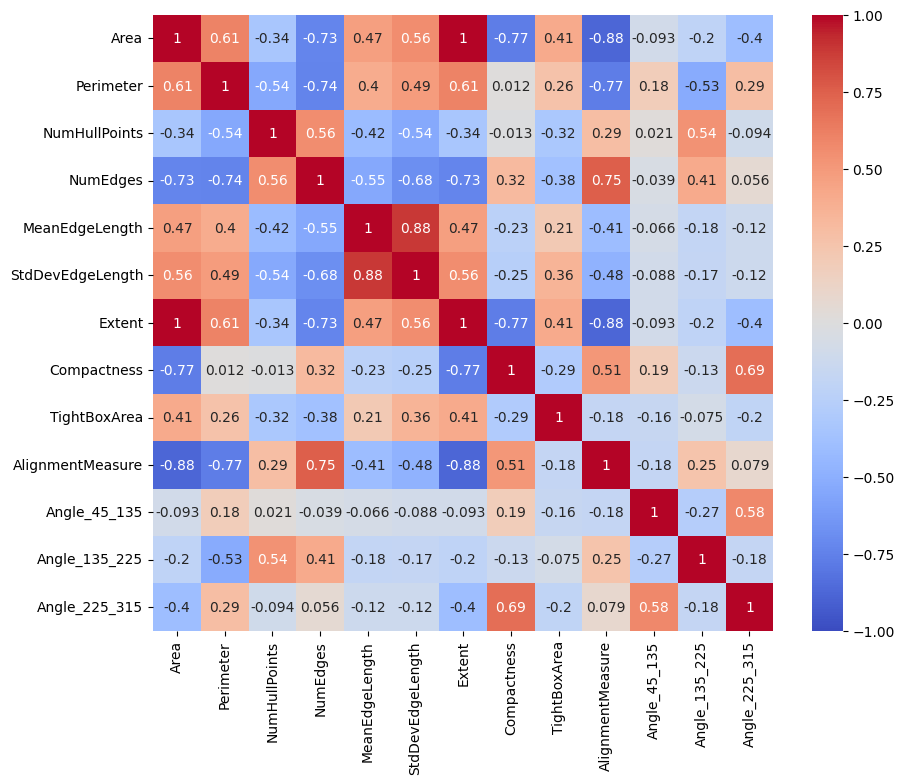

In [21]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [22]:
result_df = result_df.drop(columns=['MeanEdgeLength','Extent'])

<h5>Dimensionality Reduction</h5>

<p>t-SNE has been used here for dimensionality reduction</p>

In [23]:
def apply_dimensionality_reduction(features, n_components=2, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    tsne_features = tsne.fit_transform(features)
    return tsne_features

<h2>Clustering into Design Families</h2>

In [24]:
def apply_kmeans(features, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    return clusters, kmeans

In [25]:
features = result_df.drop(columns=['Image'])

In [26]:
def find_optimal_clusters(features, max_clusters=10):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    perplexity = min(30, len(scaled_features) - 1)  # Ensure perplexity is less than the number of samples
    reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_features = reducer.fit_transform(scaled_features)

    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        clusters, _ = apply_kmeans(reduced_features, n_clusters)
        score = silhouette_score(reduced_features, clusters)
        silhouette_scores.append((n_clusters, score))

    optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
    return optimal_clusters, silhouette_scores

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters using t-SNE: 3


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         Area    Perimeter  NumHullPoints  NumEdges  StdDevEdgeLength  \
0    130400.5  1496.918828             20       272          9.927440   
1    143171.5  1510.149273             10        85         62.852891   
2    103137.5  1381.584913             21       434         11.133660   
3    133053.5  1509.747254             22       238         15.266305   
4    114116.0  1434.582822             16       479          5.457036   
..        ...          ...            ...       ...               ...   
160  135759.0  1524.450791             13       179         29.665059   
161  146943.0  1563.254833             16        62         30.548730   
162  147426.0  1561.941125             15        50         36.278738   
163  126436.5  1495.747254             14       230         27.160912   
164  144064.5  1554.325901             14        77         30.141581   

     Compactness  TightBoxArea  AlignmentMeasure  Angle_45_135  Angle_135_225  \
0      17.183722      149647.5          1.

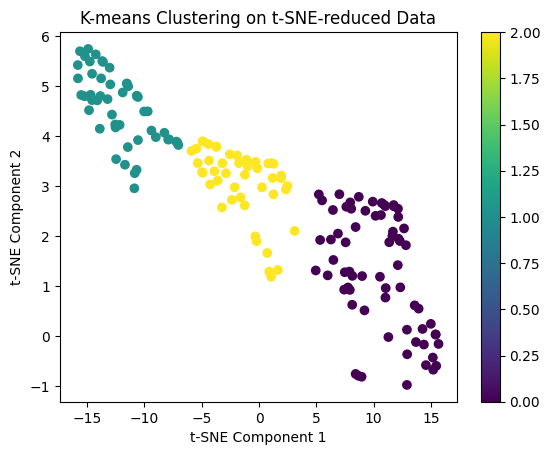

In [27]:
features = result_df.drop(columns=['Image', 'Cluster_tSNE'], errors='ignore') 

# Finding optimal clusters using t-SNE reduced features
optimal_clusters_tsne, silhouette_scores_tsne = find_optimal_clusters(features, max_clusters=10)
print(f'Optimal number of clusters using t-SNE: {optimal_clusters_tsne}')

# Applying t-SNE for dimensionality reduction
perplexity = min(30, len(features) - 1)
tsne_features = apply_dimensionality_reduction(features, n_components=2, perplexity=perplexity)
result_df['tSNE1'] = tsne_features[:, 0]
result_df['tSNE2'] = tsne_features[:, 1]

# Applying K-means clustering on t-SNE reduced data
clusters_tsne, kmeans_tsne = apply_kmeans(tsne_features, optimal_clusters_tsne)
result_df['Cluster_tSNE'] = clusters_tsne

# Print the resulting DataFrame
print(result_df)

# Plotting the t-SNE results with K-means clusters
plt.scatter(result_df['tSNE1'], result_df['tSNE2'], c=result_df['Cluster_tSNE'], cmap='viridis')
plt.colorbar()
plt.title('K-means Clustering on t-SNE-reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

<h5>Grouping the designs according to the complexities</h5>

In [28]:
def classify_complexity(df):
    conditions = [
        (df['Compactness'] <= 17),
        (df['Compactness'] <= 19) & (df['Compactness'] > 17),
        (df['Compactness'] > 19)
    ]
    choices = ['Low', 'Medium', 'High']
    df['Complexity'] = np.select(conditions, choices, default='Unknown')
    return df

In [29]:
result_df = classify_complexity(result_df)
result_df = result_df.drop(columns=['Image'])
result_df.head()

,Area,Perimeter,NumHullPoints,NumEdges,StdDevEdgeLength,Compactness,TightBoxArea,AlignmentMeasure,Angle_45_135,Angle_135_225,Angle_225_315,tSNE1,tSNE2,Cluster_tSNE,Complexity
0,130400.5,1496.918828,20,272,9.927440,17.183722,149647.5,1.141550,4,0,0,-2.136415,2.974231,2,Medium
1,143171.5,1510.149273,10,85,62.852891,15.928804,151536.0,1.056659,4,1,0,-9.716311,4.492740,1,Low
2,103137.5,1381.584913,21,434,11.133660,18.507108,150735.0,1.362773,6,1,0,10.159595,2.403383,0,Medium
3,133053.5,1509.747254,22,238,15.266305,17.130979,147791.0,1.095154,4,0,0,-3.247063,2.570616,2,Medium
4,114116.0,1434.582822,16,479,5.457036,18.034525,150974.0,1.315271,4,1,0,5.492435,2.712007,0,Medium


In [30]:
result_df['Complexity'].value_counts()

Complexity
Low       60
Medium    55
High      50
Name: count, dtype: int64

In [31]:
X = result_df.drop(columns=['Complexity'])
y = result_df['Complexity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9696969696969697
Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.90      0.95        10
         Low       1.00      1.00      1.00        14
      Medium       0.90      1.00      0.95         9

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.96        33
weighted avg       0.97      0.97      0.97        33



In [33]:
cross_val_scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())
print("Standard Deviation of Cross-Validation Scores:", cross_val_scores.std())

Cross-Validation Scores: [0.96969697 0.93939394 0.96969697 1.         1.        ]
Mean Cross-Validation Score: 0.9757575757575758
Standard Deviation of Cross-Validation Scores: 0.022676711434993564


In [34]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samp

In [35]:
features = result_df.drop(columns=['Image', 'Cluster_tSNE', 'tSNE1', 'tSNE2','Complexity'], errors='ignore')
labels = result_df['Cluster_tSNE']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [37]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [38]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

In [39]:
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.2f}')
print(f'Standard Deviation of CV Accuracy: {cv_scores.std():.2f}')

Cross-Validation Accuracy Scores: [0.96296296 1.         1.         1.         1.        ]
Mean CV Accuracy: 0.99
Standard Deviation of CV Accuracy: 0.01


In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [41]:
y_pred = pipeline.predict(X_test)

# Evaluating the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test Set Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

